# Project 1: Higgs Boson Detection

In [1]:
import numpy as np
from regression_tools import * 
import matplotlib.pyplot as plt

## Loading files

In [ ]:
with open('test.csv') as csv_file_test:
    test_reader=csv.reader(csv_file_test,delimiter=',')
    test_list=[]
    for row in test_reader:
        test_list.append(row)
    y_test=[]
    x_test_list=[]
    for test_row in test_list:
        y_test.append(test_row[1])
        test_row.pop(1)
        x_test_list.append(test_row)
    x_test=np.array(x_test_list)

In [ ]:
x_test.shape

In [ ]:
def load_data(train_path,test_path):
    train_reader=np.genfromtxt(train_path,delimiter=',',missing_values=-999)
    train_list=[]
    for row in train_reader:
        train_list.append(row)
    y_train_bool=[]
    x_train_l=[]
    for train_row in train_list:
        train_row=np.ndarray.tolist(train_row)
        y_train_bool.append(train_row[1]=='b')
        train_row.pop(1)
        x_train_l.append(train_row)
    Data_structure_X=x_train_l[0]
    x_train_l.pop(0)
    y_train_bool.pop(0)
    x_train=np.array(x_train_l)
    y_train=np.array(y_train_bool)
    
    
    test_reader=np.genfromtxt(test_path,delimiter=',')
    test_list=[]
    for row in test_reader:
        test_list.append(row)
    #y_test_l=[]
    x_test_l=[]
    for test_row in test_list:
        test_row=np.ndarray.tolist(test_row)
        #y_test_l.append(test_row[1])
        test_row.pop(1)
        x_test_l.append(test_row)
    x_test_l.pop(0)
    #y_test_l.pop(0)
    #y_test_bool=[y_test_l[:]==a]
    x_test=np.array(x_test_l)
    #y_test=np.array(y_test_bool)
    return x_train,y_train,x_test,Data_structure_X
        

In [ ]:
train_reader=np.genfromtxt('train.csv',delimiter=',',dtype=None,skip_header=1)
train_reader=np.ndarray.tolist(train_reader)


In [ ]:
type(train_reader)

In [ ]:
a=np.array(train_reader)[:,2:]

In [ ]:
b=a.astype(np.float)

In [ ]:
b

In [ ]:
dt=np.dtype('float,object'+30*',float')
xar=np.array(train_reader,dtype=dt)

In [2]:
def load_data(train_path,test_path):
    train_reader=np.genfromtxt(train_path,delimiter=',',skip_header=1,converters={1:lambda s: float(0) if s==b'b' else float(1)})
    y_train=train_reader[:,1]
    x_train=train_reader[:,2:]
    test_reader=np.genfromtxt(test_path,delimiter=',')
    x_test=test_reader[:,2:]
    return x_train,y_train,x_test

In [3]:
 x_train,y_train,x_test=load_data('train.csv','test.csv')

In [ ]:
x_train

In [4]:
# to do: implement cross validation
results=[]
for j in range(1,12):
    phi_train=build_polinomial(x_train,j,nmc_tr)
    loss,w=least_squares(y_train,phi_train)
    result=(y_train==(phi_train.dot(w)>0.5)).sum()/y_train.shape[0]
    results.append(result)
plt.figure
plt.plot(range(1,12),results)
plt.xlabel('degree')
plt.ylabel('train accuracy')
plt.show()

NameError: name 'build_polinomial' is not defined

In [ ]:
plt.show()

In [5]:
def nan_converter(x,nm=-999,direction=True):
    """convert the not measured elements of the matrix in nan, 
    if direction=False the opposite conversion is made"""
    if direction:
        inds=np.where(x[:,:]==nm)
        x[inds]=np.nan
    else:
        inds=np.where(np.isnan(x))
        x[inds]=nm
    return x
        

In [6]:
def find_cluster(x_bool):
    v_bool=x_bool.sum(0)
    nb_cluster=0
    index_clusters=[]
    while np.max(v_bool)>0:
        index_clusters.append(np.argmax(v_bool))
        nb_cluster+=1
        v_bool=v_bool*(v_bool[:]!=np.max(v_bool))
    return nb_cluster, index_clusters

In [7]:
def cleaning_function(x,nm=-999):
    # nm= not_measured
    x_bool=x[:,:]==nm
    nb_cluster,index_clusters=find_cluster(x_bool)
    v=x[:,index_clusters]!=nm
    x=np.concatenate((x,v,(np.prod(v,axis=1)).reshape(-1,1)),axis=1)
    inds=np.where(x_bool)
    x[inds]=np.nan
    col_mean=np.nanmean(x,axis=0)
    x[inds]=np.take(col_mean,inds[1])
    return x,nb_cluster

In [8]:
def build_polinomial(x,degree,not_poly_features=0,nm=-999):
    """create polynomial features until specified degree. It doesn't 
    compute the power of the last n columns of the metrix, n specified in 
    not_poly_features"""
    x=nan_converter(x,nm=nm,direction=True)
    phi_list=[np.ones(x.shape[0]).reshape(-1,1)]
    # is it possible to avoid the loop?
    for i in range(1,degree+1):
        phi_list.append(np.power(x[:,0:x.shape[1]-1-not_poly_features],i))
    if not_poly_features>0:
        phi_list.append(x[:,x.shape[1]-1-not_poly_features:])
    phi=np.concatenate(phi_list,axis=1)
    phi=nan_converter(phi,nm=nm,direction=False)
    return phi

In [ ]:
#x_train,nmc_tr=cleaning_function(x_train,-999)
#x_test,nmc_te=cleaning_function(x_test,-999)
# nmc= nb of not measured column, i.e. columns where 
#it is present at least one not measured element
#phi_train=build_polinomial(x_train,4,nmc_tr)

In [ ]:
print(phi_train[3])

In [9]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [29]:
def LOO_cross_validation(y, phi, k_indices, k, lambda_, degree, nmc_tr):
    """return the loss of ridge/linear regression."""
    """Probabilmente conviene implementare una per la regressione normale, in modo da capire 
    quale sia il grado massimo oltre il quale non ha senso andare e poi lavorare con lambda 
    per capire come eliminare feature"""
    
    
    # Get k'th subgroup in test, others in train    
    train_indices = np.delete(k_indices , k , 0).reshape((k_indices.shape[0]-1) * k_indices.shape[1])
    x_test = phi[k_indices[k],:]
    x_train = phi[train_indices,:]
    y_test = y[k_indices[k]]
    y_train = y[train_indices]
    
    # Form data with polynomial degree
    tx_train = build_polinomial(x_train, degree, nmc_tr)
    tx_test = build_polinomial(x_test, degree, nmc_tr)
    #print(tx_test.shape)
    #print(tx_train.shape)
    #print(y_train.shape)
    # Ridge regression / Linear regression
    loss , w = _regression(y_train, tx_train, lambda_)
    #loss , w = least_squares(y_train,tx_train)
    print('REGRESSION DONE')
    #print(y_test.shape)
    #print(w.shape)
    
    # Calculate results
    result=(y_test==(tx_test.dot(w)>0.5)).sum()/y_test.shape[0]
    print('RESULT CALCULATED')
    return result

In [30]:
#def cross_validation_degree():
    
seed = 1
degrees = np.arange(1,3)
k_fold = 4
# To use ridge regression
lambdas = 10**-2
    
# split data in k fold
k_indices = build_k_indices(y_train, k_fold, seed)
    
# define lists to store the loss of training data and test data
cost_te = []

# Clean data
x_train_cleaned,nmc_tr=cleaning_function(x_train,-999)
       
# cross validation
for ind, degree_ in enumerate(degrees):
    print('DEGREE IS: ')
    print(degree_)
    loss_te = np.zeros(k_fold)
    for k in range (k_fold):
        print('K CONSIDERED IS: ')
        print(k)
        result = LOO_cross_validation(y_train, x_train_cleaned, k_indices, k , lambdas, degree_, nmc_tr)
        loss_te[k]= result
        
    cost_te.append(loss_te.mean())


#cross_validation_degree()

DEGREE IS: 
1
K CONSIDERED IS: 
0
(62500,)
(187500,)
(250000,)
(187500, 35)
REGRESSION DONE
RESULT CALCULATED
K CONSIDERED IS: 
1
(62500,)
(187500,)
(250000,)
(187500, 35)
REGRESSION DONE
RESULT CALCULATED
K CONSIDERED IS: 
2
(62500,)
(187500,)
(250000,)
(187500, 35)
REGRESSION DONE
RESULT CALCULATED
K CONSIDERED IS: 
3
(62500,)
(187500,)
(250000,)
(187500, 35)
REGRESSION DONE
RESULT CALCULATED
DEGREE IS: 
2
K CONSIDERED IS: 
0
(62500,)
(187500,)
(250000,)
(187500, 65)
REGRESSION DONE
RESULT CALCULATED
K CONSIDERED IS: 
1
(62500,)
(187500,)
(250000,)
(187500, 65)
REGRESSION DONE
RESULT CALCULATED
K CONSIDERED IS: 
2
(62500,)
(187500,)
(250000,)
(187500, 65)
REGRESSION DONE
RESULT CALCULATED
K CONSIDERED IS: 
3
(62500,)
(187500,)
(250000,)
(187500, 65)
REGRESSION DONE
RESULT CALCULATED


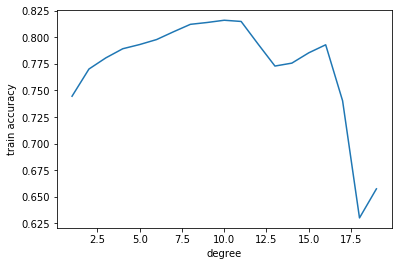

In [14]:
# Plot the results    
plt.figure
plt.plot(range(1,20),cost_te)
plt.xlabel('degree')
plt.ylabel('train accuracy')
plt.show()

In [ ]:
# DA PERFEZIONARE ANCORA

from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    for ind, lambda_ in enumerate(lambdas):
        loss_tr = np.zeros(k_fold)
        loss_te = np.zeros(k_fold)
        for k in range (k_fold):
            temp_tr, temp_te = cross_validation(y, x, k_indices, k , lambda_, degree)
            loss_tr[k]= temp_tr
            loss_te[k]= temp_te
        
        rmse_tr.append(loss_tr.mean())
        rmse_te.append(loss_te.mean())
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

In [ ]:
a=0
a=a+1
a

In [ ]:
? np.genfromtxt()

In [ ]:
np.nan

In [ ]:
? np.mean

In [ ]:
? np.argmin

In [ ]:
a=np.array([1,2,3,4,5])
b=np.concatenate([a.reshape(-1,1),a.reshape(-1,1)],axis=1)
print(b)